# Sfaira automatic analysis (zero shot)

Here, we are showing a few examples of automated analysis with sfaira, comparing annotated objects with predicted annotations.

# Load data

In [1]:
# !mkdir data
# !mkdir panels
# !cd data

# Note on data download: The download links are temporary and are therefore not hard coded here.
# Pancreas data:
# Get download link for .h5ad from here https://cellxgene.cziscience.com/collections/6e8c5415-302c-492a-a5f9-f29c57ff18fb and download.
# mv local.h5ad 6e8c5415-302c-492a-a5f9-f29c57ff18fb.h5ad

# Eye data:
# Get download link for .h5ad from here https://cellxgene.cziscience.com/collections/7edef704-f63a-462c-8636-4bc86a9472bd
# mv local.h5ad 7edef704-f63a-462c-8636-4bc86a9472bd.h5ad

# Kidney data:
# Get download link for .h5ad from here https://cellxgene.cziscience.com/collections/9b02383a-9358-4f0f-9795-a891ec523bcc
# mv local.h5ad 9b02383a-9358-4f0f-9795-a891ec523bcc.h5ad

# Heart data:
# Get download link for .h5ad from here https://cellxgene.cziscience.com/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72
# mv local.h5ad b52eb423-5d0d-4645-b217-e1c6d38b2e72.h5ad

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import warnings

import sfaira

model_dir = '.'

sc.settings.verbosity = 3
sc.settings.figdir = "panels/"
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(6, 6), facecolor='white')

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Ontology <class 'sfaira.versions.metadata.base.OntologyMondo'> is not a DAG, treat child-parent reasoning with care.
Ontology <class 'sfaira.versions.metadata.base.OntologyUberon'> is not a DAG, treat child-parent reasoning with care.


# Utils

In [4]:
def plot_zeroshot(adata, adata_sfaira, fn, embedding="umap", figsize=(16,4)):
    # Make labels plotting ready:
    adata.obs["celltypes_sfaira"] = [adata_sfaira.obs.loc[x, "celltypes_sfaira"] for x in adata.obs_names]
    categories = np.sort(list(set(adata.obs["cell_type"].values.tolist()).union(
        set(adata_sfaira.obs["celltypes_sfaira"].values.tolist())
    )))
    adata.obs["cell_type"] = pd.Categorical(
        adata.obs["cell_type"].values.tolist(), categories=categories)
    adata.obs["celltypes_sfaira"] = pd.Categorical(
        adata.obs["celltypes_sfaira"].values.tolist(), categories=categories)
    adata_sfaira.obs["celltypes_sfaira"] = pd.Categorical(
        adata_sfaira.obs["celltypes_sfaira"].values.tolist(), categories=categories)
    import matplotlib
    import matplotlib.pyplot as plt
    sc.settings.set_figure_params(dpi=80, frameon=True, figsize=(6, 6), facecolor='white')

    fig, axs = plt.subplots(1, 3, figsize=figsize)
    if embedding == "umap":
        sc.pl.umap(adata, color="cell_type", show=False, title="curated embedding\ncurated cell type", ax=axs[0])
    else:
        sc.pl.tsne(adata, color="cell_type", show=False, title="curated embedding\ncurated cell type", ax=axs[0])
    axs[0].legend_.remove()

    if embedding == "umap":
        sc.pl.umap(adata, color="celltypes_sfaira", show=False, title="curated embedding\nsfaira cell type", ax=axs[1])
    else:
        sc.pl.tsne(adata, color="celltypes_sfaira", show=False, title="curated embedding\nsfaira cell type", ax=axs[1])
    axs[1].legend_.remove()
    axs[1].set_ylabel("")

    if embedding == "umap":
        sc.pl.umap(adata_sfaira, color="celltypes_sfaira", show=False, title="sfaira embedding\nsfaira cell type", ax=axs[2])
    else:
        sc.pl.tsne(adata_sfaira, color="celltypes_sfaira", show=False, title="sfaira embedding\nsfaira cell type", ax=axs[2])
    axs[2].set_ylabel("")

    plt.tight_layout()
    plt.savefig(os.path.join(sc.settings.figdir, f"{fn}.pdf"))
    plt.show()

In [5]:
def plot_confusion_matrix(adata, adata_sfaira, fn, figsize=(10,10), map_names=None, log=False):
    import matplotlib.pyplot as plt
    import seaborn as sns
    adata.obs["celltypes_sfaira"] = [adata_sfaira.obs.loc[x, "celltypes_sfaira"] for x in adata.obs_names]
    types_obs = adata.obs["cell_type"].values.tolist()
    types_hat = adata.obs["celltypes_sfaira"].values.tolist()
    if map_names is not None:
        types_obs = [map_names[x] for x in types_obs]
        types_hat = [map_names[x] for x in types_hat]
    categories = np.sort(list(set(types_obs).union(set(types_hat)))).tolist()
    confusion_matrix = np.zeros((len(categories), len(categories)))
    for x, y in zip(types_obs, types_hat):
        i = categories.index(y)
        j = categories.index(x)
        confusion_matrix[i, j] = confusion_matrix[i, j] + 1
    if log:
        confusion_matrix = np.log(confusion_matrix + 1) / np.log(10)
    confusion_matrix = pd.DataFrame(confusion_matrix, index=categories, columns=categories)
    confusion_matrix = confusion_matrix.iloc[confusion_matrix.values.sum(axis=1) > 0,
                                             confusion_matrix.values.sum(axis=0) > 0].copy()
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax = sns.heatmap(confusion_matrix, cmap="YlGnBu", ax=ax)
    ax.set_xlabel("curated")
    ax.set_ylabel("predicted")
    plt.tight_layout()
    plt.savefig(os.path.join(sc.settings.figdir, f"{fn}_confusion_matrix.pdf"))
    plt.show()
    return confusion_matrix

# Pancreas data

In [6]:
adata = sc.read_h5ad('data/6e8c5415-302c-492a-a5f9-f29c57ff18fb.h5ad')
adata.obs["curated_annotation"] = adata.obs["cell_type"].values
adata.var.index = [x.split("__")[0] for x in adata.var.index]
adata_sfaira = adata.copy()
adata

AnnData object with n_obs × n_vars = 2126 × 7117
    obs: 'cellular_classification', 'Sex', 'Age', 'tissue_ontology_term_id', 'tissue', 'assay_ontology_term_id', 'assay', 'disease_ontology_term_id', 'disease', 'cell_type_ontology_term_id', 'cell_type', 'sex', 'ethnicity_ontology_term_id', 'ethnicity', 'development_stage_ontology_term_id', 'development_stage', 'curated_annotation'
    var: 'hgnc_gene_symbol'
    uns: 'layer_descriptions', 'organism', 'organism_ontology_term_id', 'organism_original', 'publication_doi', 'title', 'version'
    obsm: 'X_tsne'

Define the models to use:

In [7]:
model_id_embedding = "embedding_human-pancreas-ae-0.1-0.1_theislab"
model_id_type = "celltype_human-pancreas-mlp-0.1.3-0.1_theislab"

In [8]:
ui = sfaira.ui.UserInterface(
    custom_repo=os.path.join(model_dir, "HUMAN"),
    sfaira_repo=False
)
ui.zoo_embedding.model_id = model_id_embedding
ui.zoo_celltype.model_id = model_id_type
ui.load_data(data=adata_sfaira, gene_symbol_col="index", gene_ens_col=None)

ui.load_model_celltype()
ui.load_model_embedding()
ui.predict_all()
adata_sfaira = ui.data.adata

sc.pp.neighbors(adata_sfaira, use_rep="X_sfaira")
sc.tl.tsne(adata_sfaira)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


passed hyperpar: 
 {'units': [512, 256, 128], 'activation': 'selu', 'use_bias': True, 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'kernel_initializer': 'lecun_normal', 'bias_initializer': 'zeros', 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'dropout_rate': 0.2}
passed hyperpar: 
 {'latent_dim': (512, 64, 512), 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'dropout_rate': 0.2, 'input_dropout': 0.0, 'batchnorm': True, 'activation': 'selu', 'init': 'lecun_normal', 'output_layer': 'nb_shared_disp'}
found 2126 observations
found 2126 observations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:11)
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:23)


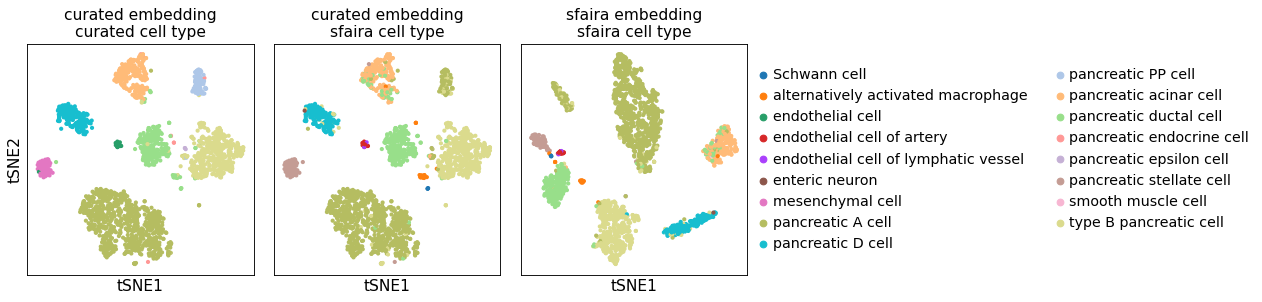

In [9]:
plot_zeroshot(adata, adata_sfaira, fn="pancreas_zeroshot", embedding="tsne")

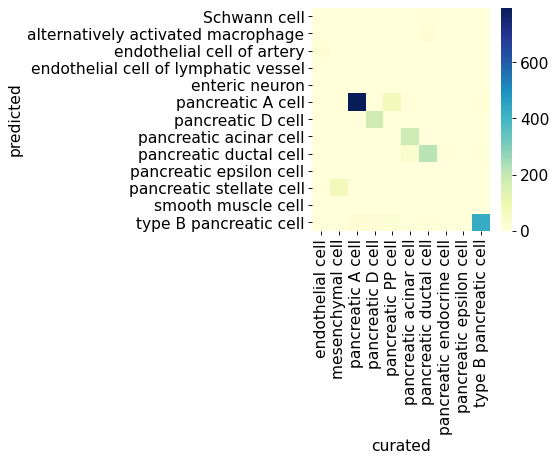

In [10]:
confusion_matrix = plot_confusion_matrix(adata, adata_sfaira, fn="pancreas_zeroshot", figsize=(7, 6))

# Eye data

In [11]:
adata = sc.read_h5ad('data/7edef704-f63a-462c-8636-4bc86a9472bd.h5ad')
adata.obs["curated_annotation"] = adata.obs["cell_type"].values
adata.var.index = [x.split("__")[0] for x in adata.var.index]
adata_sfaira = adata.copy()
adata

AnnData object with n_obs × n_vars = 8217 × 21599
    obs: 'final_cluster_labels', 'libraryID', 'celltype', 'region', 'development_stage_ontology_term_id', 'development_stage', 'disease_ontology_term_id', 'disease', 'assay_ontology_term_id', 'assay', 'ethnicity_ontology_term_id', 'ethnicity', 'sex', 'tissue_ontology_term_id', 'tissue', 'cell_type_ontology_term_id', 'cell_type', 'curated_annotation'
    var: 'hgnc_gene_symbol'
    uns: 'layer_descriptions', 'organism', 'organism_ontology_term_id', 'title', 'version'
    obsm: 'X_umap'

Define the models to use:

In [12]:
model_id_embedding = "embedding_human-eye-ae-0.1-0.1_theislab"
model_id_type = "celltype_human-eye-mlp-0.1.1-0.1_theislab"

In [13]:
ui = sfaira.ui.UserInterface(
    custom_repo=os.path.join(model_dir, "HUMAN"),
    sfaira_repo=False
)
ui.zoo_embedding.model_id = model_id_embedding
ui.zoo_celltype.model_id = model_id_type
ui.load_data(data=adata_sfaira, gene_symbol_col="index", gene_ens_col=None)

ui.load_model_celltype()
ui.load_model_embedding()
ui.predict_all()
adata_sfaira = ui.data.adata

sc.pp.neighbors(adata_sfaira, use_rep="X_sfaira")
sc.tl.umap(adata_sfaira)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


passed hyperpar: 
 {'units': [128], 'activation': 'selu', 'use_bias': True, 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'kernel_initializer': 'lecun_normal', 'bias_initializer': 'zeros', 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'dropout_rate': 0.2}
passed hyperpar: 
 {'latent_dim': (512, 64, 512), 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'dropout_rate': 0.2, 'input_dropout': 0.0, 'batchnorm': True, 'activation': 'selu', 'init': 'lecun_normal', 'output_layer': 'nb_shared_disp'}
found 8217 observations
found 8217 observations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


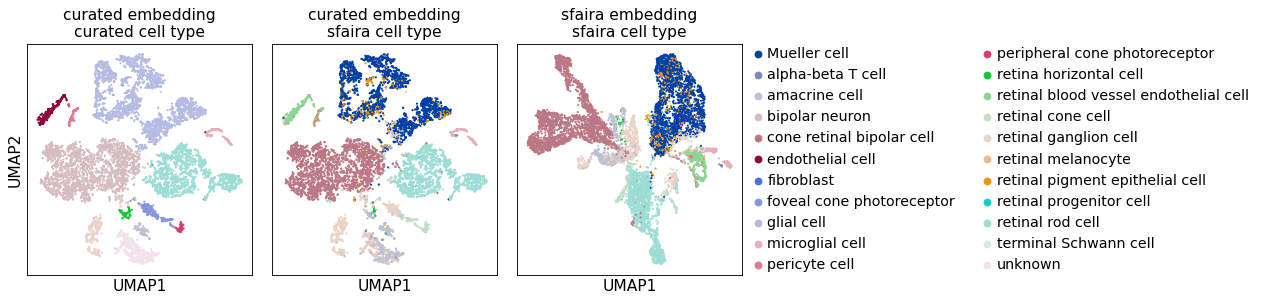

In [14]:
plot_zeroshot(adata, adata_sfaira, fn="eye_zeroshot")

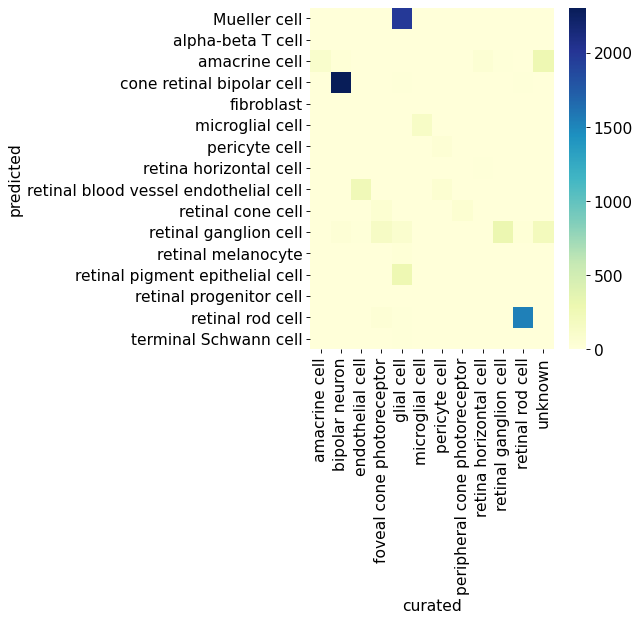

In [15]:
confusion_matrix = plot_confusion_matrix(adata, adata_sfaira, fn="eye_zeroshot", figsize=(8, 8))

In [16]:
union = list(set(confusion_matrix.columns.tolist()).intersection(set(confusion_matrix.index.tolist())))
diff0 = list(set(confusion_matrix.columns.tolist()).difference(set(confusion_matrix.index.tolist())))
diff1 = list(set(confusion_matrix.index.tolist()).difference(set(confusion_matrix.columns.tolist())))
print(union)
print(diff0)
print(diff1)
map_onto = {
    # union
    'microglial cell': 'microglial cell', 
    'retinal ganglion cell': 'retinal ganglion cell', 
    'retina horizontal cell': 'retina horizontal cell', 
    'pericyte cell': 'pericyte cell', 
    'amacrine cell': 'amacrine cell', 
    'retinal rod cell': 'retinal rod cell',
    # diff 0
    'unknown': 'unknown', 
    'peripheral cone photoreceptor': 'bipolar neuron',
    'bipolar neuron': 'bipolar neuron', 
    'glial cell': 'glial cell', 
    'endothelial cell': 'endothelial cell',
    'foveal cone photoreceptor': 'foveal cone photoreceptor',
    # diff 1
    'cone retinal bipolar cell': 'bipolar neuron', 
    'retinal cone cell': 'retinal cone cell', 
    'terminal Schwann cell': 'glial cell', 
    'retinal blood vessel endothelial cell': 'endothelial cell',
    'retinal pigment epithelial cell': 'retinal pigment epithelial cell', 
    'retinal melanocyte': 'retinal melanocyte', 
    'fibroblast': 'fibroblast',
    'retinal progenitor cell': 'retinal progenitor cell',
    'Mueller cell': 'glial cell',  
    'alpha-beta T cell': 'T cell',
}

['pericyte cell', 'retinal ganglion cell', 'retina horizontal cell', 'amacrine cell', 'microglial cell', 'retinal rod cell']
['endothelial cell', 'unknown', 'bipolar neuron', 'foveal cone photoreceptor', 'peripheral cone photoreceptor', 'glial cell']
['retinal pigment epithelial cell', 'retinal cone cell', 'retinal melanocyte', 'Mueller cell', 'cone retinal bipolar cell', 'retinal blood vessel endothelial cell', 'terminal Schwann cell', 'fibroblast', 'alpha-beta T cell', 'retinal progenitor cell']


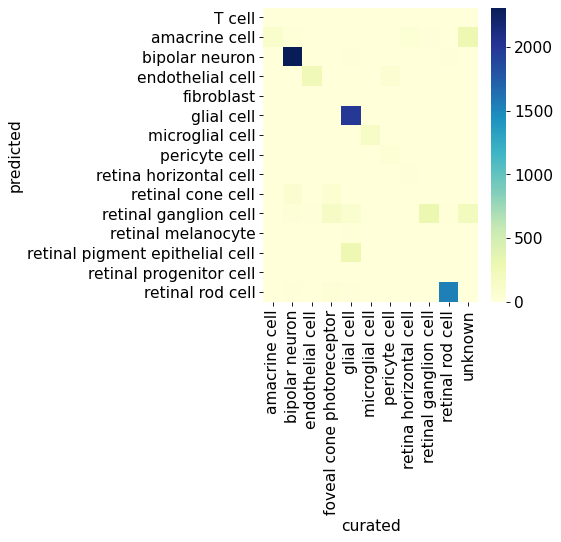

In [17]:
_ = plot_confusion_matrix(adata, adata_sfaira, fn="eye_zeroshot_homogenised", 
                          figsize=(7, 7), map_names=map_onto)

# Kidney data

In [18]:
adata = sc.read_h5ad('data/9b02383a-9358-4f0f-9795-a891ec523bcc.h5ad')
adata.obs["curated_annotation"] = adata.obs["cell_type"].values
adata.var.index = [x.split("__")[0] for x in adata.var.index]
adata_sfaira = adata.copy()
adata

AnnData object with n_obs × n_vars = 19985 × 22357
    obs: 'assay', 'assay_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'donor_age', 'donor_uuid', 'ethnicity', 'ethnicity_ontology_term_id', 'library_uuid', 'sample_preservation_method', 'sample_uuid', 'sex', 'suspension_suspension_type', 'suspension_uuid', 'tissue', 'tissue_ontology_term_id', 'disease', 'disease_ontology_term_id', 'reported_diseases', 'author_cell_type', 'cell_type', 'cell_type_category', 'cell_type_ontology_term_id', 'author_cluster', 'curated_annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'default_embedding', 'default_field', 'layer_descriptions', 'organism', 'organism_ontology_term_id', 'reference_annotation_version', 'title', 'version'
    obsm: 'X_umap'

Define the models to use:

In [19]:
model_id_embedding = "embedding_human-kidney-linear-0.1-0.1_theislab"
model_id_type = "celltype_human-kidney-mlp-0.0.1-0.1_theislab"

In [20]:
ui = sfaira.ui.UserInterface(
    custom_repo=os.path.join(model_dir, "HUMAN"),
    sfaira_repo=False
)
ui.zoo_embedding.model_id = model_id_embedding
ui.zoo_celltype.model_id = model_id_type
ui.load_data(data=adata_sfaira, gene_symbol_col="index", gene_ens_col=None)

ui.load_model_celltype()
ui.load_model_embedding()
ui.predict_all()
adata_sfaira = ui.data.adata

sc.pp.neighbors(adata_sfaira, use_rep="X_sfaira")
sc.tl.umap(adata_sfaira)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


passed hyperpar: 
 {'units': [], 'activation': None, 'use_bias': True, 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'kernel_initializer': 'glorot_uniform', 'bias_initializer': 'zeros', 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'dropout_rate': 0.2}
passed hyperpar: 
 {'latent_dim': 64, 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'positive_components': False, 'output_layer': 'nb_shared_disp', 'dropout_rate': 0.2}
found 19985 observations
found 19985 observations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


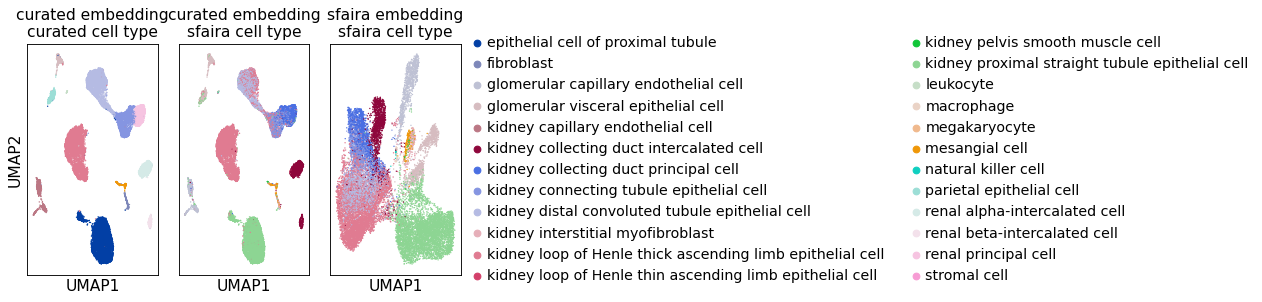

In [21]:
plot_zeroshot(adata, adata_sfaira, fn="kidney_zeroshot")

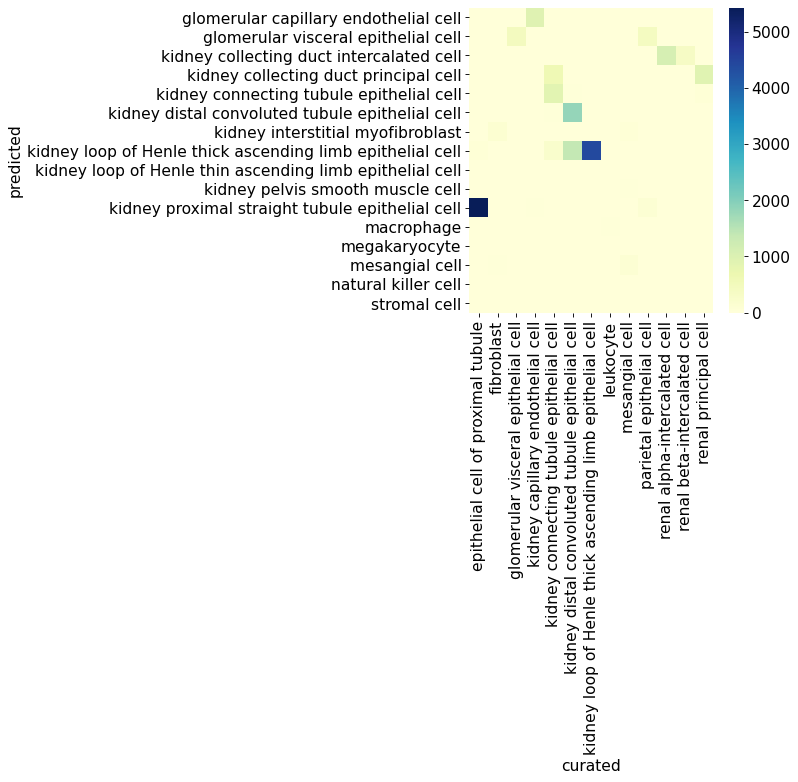

In [22]:
confusion_matrix = plot_confusion_matrix(adata, adata_sfaira, fn="kidney_zeroshot", figsize=(10, 10))

In [23]:
union = list(set(confusion_matrix.columns.tolist()).intersection(set(confusion_matrix.index.tolist())))
diff0 = list(set(confusion_matrix.columns.tolist()).difference(set(confusion_matrix.index.tolist())))
diff1 = list(set(confusion_matrix.index.tolist()).difference(set(confusion_matrix.columns.tolist())))
print(union)
print(diff0)
print(diff1)
map_onto = {
    # union
    'glomerular visceral epithelial cell': 'glomerular visceral epithelial cell', 
    'mesangial cell': 'mesangial cell', 
    'kidney loop of Henle thick ascending limb epithelial cell': 'epithelial cell of distal tubule', 
    'kidney distal convoluted tubule epithelial cell': 'epithelial cell of distal tubule', 
    'kidney connecting tubule epithelial cell': 'kidney connecting tubule epithelial cell',
    # diff 0
    'renal beta-intercalated cell': 'intercalated cell', 
    'renal principal cell': 'renal principal cell', 
    'leukocyte': 'leukocyte', 
    'fibroblast': 'fibroblast', 
    'renal alpha-intercalated cell': 'intercalated cell', 
    'epithelial cell of proximal tubule': 'epithelial cell of proximal tubule', 
    'parietal epithelial cell': 'parietal epithelial cell', 
    'kidney capillary endothelial cell': 'kidney capillary endothelial cell',
    # diff 1
    'glomerular capillary endothelial cell':  'glomerular capillary endothelial cell', 
    'kidney loop of Henle thin ascending limb epithelial cell': 'epithelial cell of distal tubule', 
    'kidney interstitial myofibroblast': 'kidney interstitial myofibroblast', 
    'kidney collecting duct principal cell': 'renal principal cell', 
    'megakaryocyte': 'leukocyte', 
    'natural killer cell': 'leukocyte', 
    'kidney pelvis smooth muscle cell': 'kidney pelvis smooth muscle cell', 
    'kidney collecting duct intercalated cell': 'intercalated cell', 
    'stromal cell': 'stromal cell', 
    'macrophage': 'leukocyte', 
    'kidney proximal straight tubule epithelial cell': 'epithelial cell of proximal tubule',
}

['glomerular visceral epithelial cell', 'kidney connecting tubule epithelial cell', 'kidney distal convoluted tubule epithelial cell', 'mesangial cell', 'kidney loop of Henle thick ascending limb epithelial cell']
['renal beta-intercalated cell', 'leukocyte', 'renal alpha-intercalated cell', 'epithelial cell of proximal tubule', 'renal principal cell', 'fibroblast', 'parietal epithelial cell', 'kidney capillary endothelial cell']
['kidney loop of Henle thin ascending limb epithelial cell', 'kidney collecting duct principal cell', 'macrophage', 'kidney proximal straight tubule epithelial cell', 'natural killer cell', 'megakaryocyte', 'kidney interstitial myofibroblast', 'stromal cell', 'kidney pelvis smooth muscle cell', 'glomerular capillary endothelial cell', 'kidney collecting duct intercalated cell']


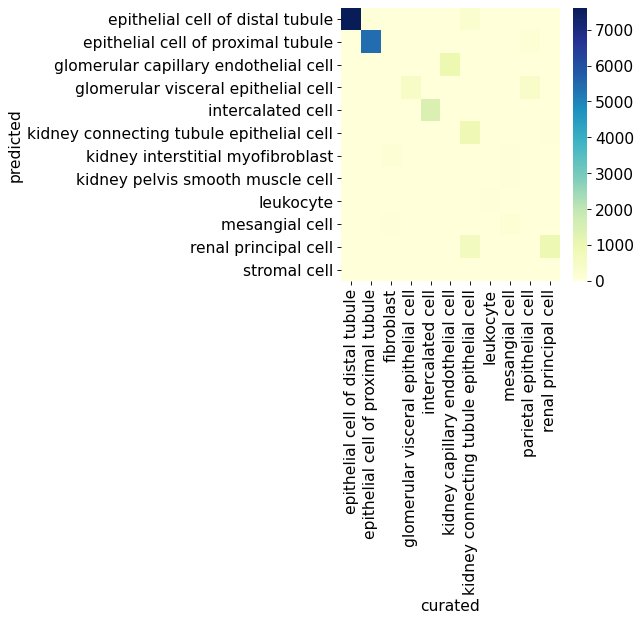

In [24]:
_ = plot_confusion_matrix(adata, adata_sfaira, fn="kidney_zeroshot_homogenised", 
                          figsize=(8, 8), map_names=map_onto)

# Heart data

In [25]:
adata = sc.read_h5ad('data/b52eb423-5d0d-4645-b217-e1c6d38b2e72.h5ad')
adata.obs["curated_annotation"] = adata.obs["cell_type"].values
adata.var.index = [x.split("__")[0] for x in adata.var.index]
sc.pp.subsample(adata, n_obs=50000)  # subsampling to speed up operations
adata_sfaira = adata.copy()
adata

AnnData object with n_obs × n_vars = 50000 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'sex', 'disease_ontology_term_id', 'disease', 'ethnicity_ontology_term_id', 'ethnicity', 'assay_ontology_term_id', 'assay', 'cell_type_ontology_term_id', 'cell_type_original', 'development_stage_ontology_term_id', 'development_stage', 'tissue_ontology_term_id', 'tissue', 'curated_annotation'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    uns: 'layer_descriptions', 'organism', 'organism_ontology_term_id', 'organism_original', 'title', 'version'
    obsm: 'X_pca', 'X_umap'

Define the models to use:

In [26]:
model_id_embedding = "embedding_human-heart-ae-0.1-0.1_theislab"
model_id_type = "celltype_human-heart-mlp-0.1.3-0.1_theislab"

In [27]:
ui = sfaira.ui.UserInterface(
    custom_repo=os.path.join(model_dir, "HUMAN"),
    sfaira_repo=False
)
ui.zoo_embedding.model_id = model_id_embedding
ui.zoo_celltype.model_id = model_id_type
ui.load_data(data=adata_sfaira, gene_symbol_col="index", gene_ens_col=None)

ui.load_model_celltype()
ui.load_model_embedding()
ui.predict_all()
adata_sfaira = ui.data.adata

sc.pp.neighbors(adata_sfaira, use_rep="X_sfaira")
sc.tl.umap(adata_sfaira)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


passed hyperpar: 
 {'units': [512, 256, 128], 'activation': 'selu', 'use_bias': True, 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'kernel_initializer': 'lecun_normal', 'bias_initializer': 'zeros', 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'dropout_rate': 0.2}
passed hyperpar: 
 {'latent_dim': (512, 64, 512), 'l1_coef': 1e-06, 'l2_coef': 1e-06, 'dropout_rate': 0.2, 'input_dropout': 0.0, 'batchnorm': True, 'activation': 'selu', 'init': 'lecun_normal', 'output_layer': 'nb_shared_disp'}
found 50000 observations
found 50000 observations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:59)


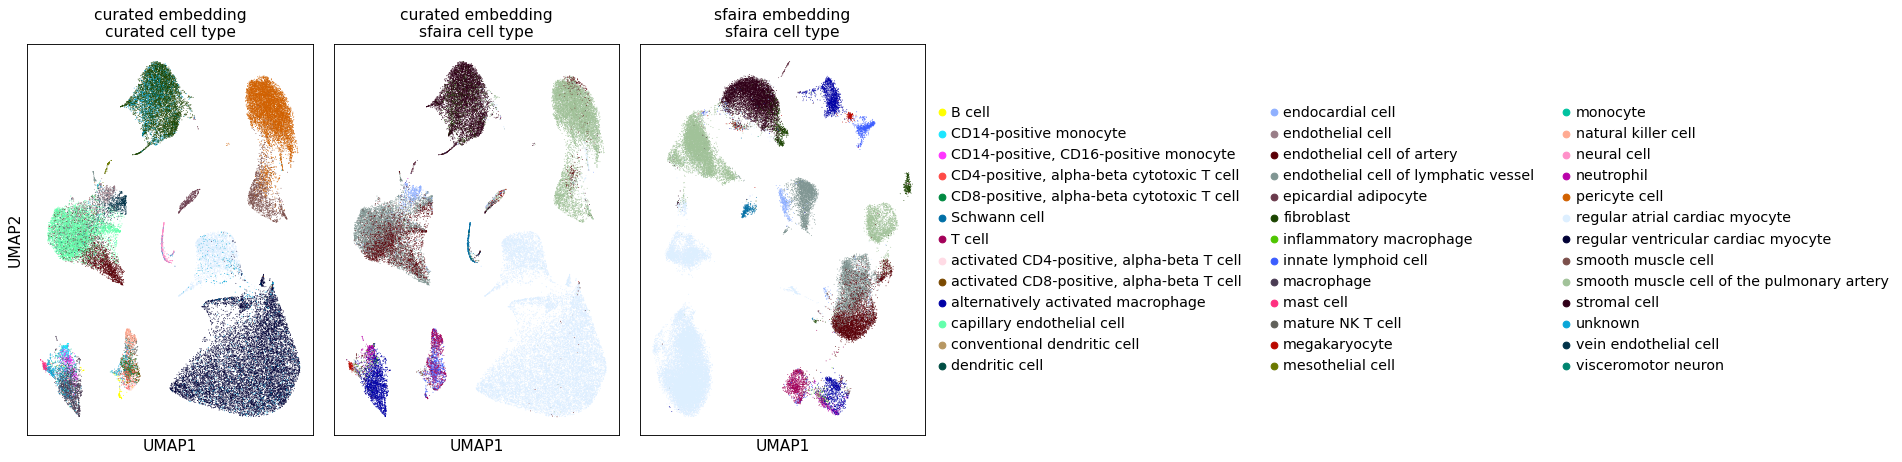

In [28]:
plot_zeroshot(adata, adata_sfaira, fn="heart_zeroshot", figsize=(24,6))

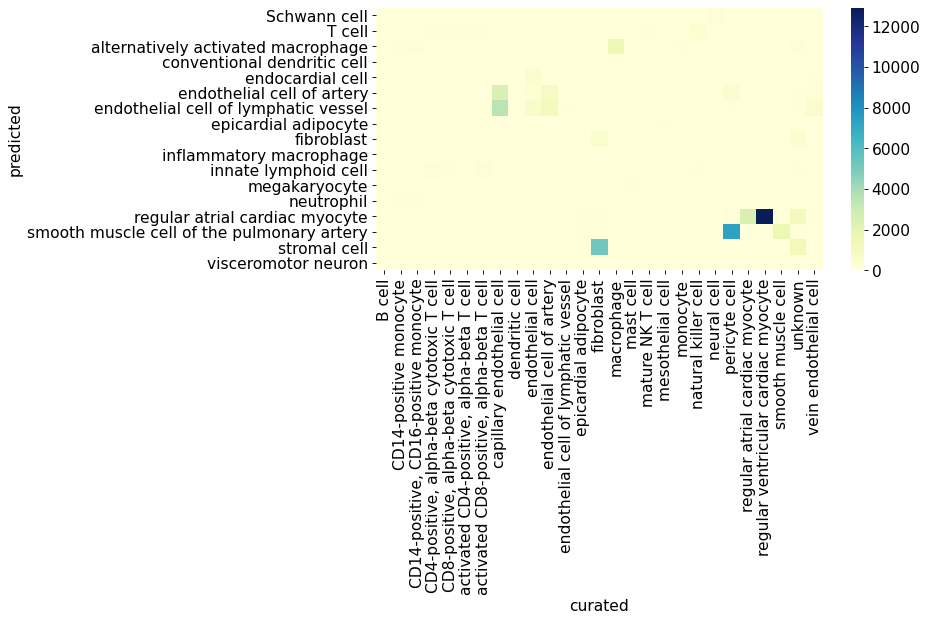

In [29]:
confusion_matrix = plot_confusion_matrix(adata, adata_sfaira, fn="heart_zeroshot", figsize=(12, 8))

In [30]:
union = list(set(confusion_matrix.columns.tolist()).intersection(set(confusion_matrix.index.tolist())))
diff0 = list(set(confusion_matrix.columns.tolist()).difference(set(confusion_matrix.index.tolist())))
diff1 = list(set(confusion_matrix.index.tolist()).difference(set(confusion_matrix.columns.tolist())))
print(union)
print(diff0)
print(diff1)
map_onto = {
    # union
    'endothelial cell of artery': 'endothelial cell', 
    'fibroblast': 'fibroblast', 
    'endothelial cell of lymphatic vessel': 'endothelial cell', 
    'epicardial adipocyte': 'epicardial adipocyte', 
    'regular atrial cardiac myocyte': 'cardiac myocyte',
    # diff 0
    'CD14-positive, CD16-positive monocyte': 'monocyte', 
    'monocyte': 'monocyte', 
    'activated CD4-positive, alpha-beta T cell': 'T cell', 
    'CD8-positive, alpha-beta cytotoxic T cell': 'T cell', 
    'activated CD8-positive, alpha-beta T cell': 'T cell', 
    'smooth muscle cell': 'smooth muscle cell', 
    'macrophage': 'macrophage', 
    'mature NK T cell': 'T cell', 
    'capillary endothelial cell': 'endothelial cell', 
    'pericyte cell': 'pericyte cell', 
    'vein endothelial cell': 'endothelial cell', 
    'unknown': 'unknown', 
    'endothelial cell': 'endothelial cell', 
    'dendritic cell': 'dendritic cell', 
    'CD4-positive, alpha-beta cytotoxic T cell': 'T cell', 
    'CD14-positive monocyte': 'monocyte', 
    'B cell': 'B cell',
    'mast cell': 'mast cell',
    'mesothelial cell': 'mesothelial cell', 
    'regular ventricular cardiac myocyte': 'cardiac myocyte', 
    'natural killer cell': 'natural killer cell', 
    'neural cell': 'neural cell',
    # diff 1
    'smooth muscle cell of the pulmonary artery': 'smooth muscle cell', 
    'visceromotor neuron': 'neural cell', 
    'innate lymphoid cell': 'innate lymphoid cell', 
    'T cell': 'T cell', 
    'alternatively activated macrophage': 'macrophage', 
    'neutrophil': 'neutrophil', 
    'Schwann cell': 'Schwann cell', 
    'megakaryocyte': 'megakaryocyte', 
    'conventional dendritic cell': 'dendritic cell', 
    'inflammatory macrophage': 'macrophage', 
    'endocardial cell': 'endothelial cell', 
    'stromal cell': 'stromal cell',
}

['epicardial adipocyte', 'regular atrial cardiac myocyte', 'endothelial cell of lymphatic vessel', 'endothelial cell of artery', 'fibroblast']
['macrophage', 'natural killer cell', 'vein endothelial cell', 'activated CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta cytotoxic T cell', 'endothelial cell', 'unknown', 'dendritic cell', 'mature NK T cell', 'regular ventricular cardiac myocyte', 'neural cell', 'B cell', 'smooth muscle cell', 'mast cell', 'CD14-positive, CD16-positive monocyte', 'pericyte cell', 'CD4-positive, alpha-beta cytotoxic T cell', 'capillary endothelial cell', 'monocyte', 'CD14-positive monocyte', 'activated CD8-positive, alpha-beta T cell', 'mesothelial cell']
['innate lymphoid cell', 'inflammatory macrophage', 'smooth muscle cell of the pulmonary artery', 'neutrophil', 'endocardial cell', 'visceromotor neuron', 'megakaryocyte', 'alternatively activated macrophage', 'T cell', 'stromal cell', 'Schwann cell', 'conventional dendritic cell']


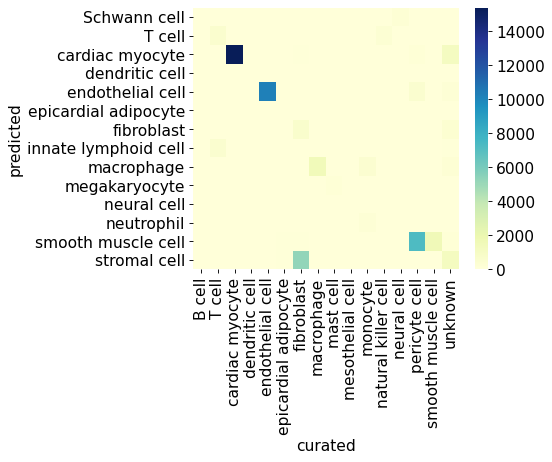

In [31]:
_ = plot_confusion_matrix(adata, adata_sfaira, fn="heart_zeroshot_homogenised", 
                          figsize=(7, 6), map_names=map_onto)